## Training CNN on CIFAR10 Dataset [1]

### CIFAR10 dataset
![CIFAR10](../pics/cifar10.png)

## Components of a DL Project

1. Dataset (CIFAR, MNIST etc)
2. Model (CNN, RNN etc)
3. Objective function (Cross entropy, MSE loss etc)
4. Optimizer (SGD, RMSProp, Adam, Adagrad etc)

### Dataloader and Transformers


To make data loading simple, we would use the torchvision package created as part of PyTorch which has data loaders for standard datasets such as ImageNet, CIFAR10, MNIST.


In [1]:
#a Tensor library with GPU support
import torch

#Datasets, Transforms and Models specific to Computer Vision
import torchvision
import torchvision.transforms as transforms

####train data
#Compose transforms (applies data transformation and augmentation) prior to feeding to training
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

#inbuilt dataset class for reading CIFAR10 dataset
trainset = torchvision.datasets.CIFAR10(root='./cifar10', train=True,
                                        download=True, transform=transform)
print("train : " + str(len(trainset)) + ' images')

#dataloader for Batching, shuffling and loading data in parallel
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)


####test data
testset = torchvision.datasets.CIFAR10(root='./cifar10', train=False,
                                       download=False, transform=transform)
print("test : " + str(len(testset)) + ' images')

testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

print(("image size : ", testset[0][0].size()))

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
train : 50000 images
test : 10000 images
('image size : ', torch.Size([3, 32, 32]))


#### Visualizing the dataset images

GroundTruth:    cat  ship  ship plane


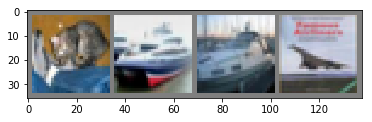

In [2]:
#plotting and visualization library
import matplotlib.pyplot as plt
#Display on the notebook
%matplotlib inline 
plt.ion() #Turn interactive mode on.

#scientific computing library for Python
import numpy as np

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

# Simple network

![cifarnet](../pics/CIFAR_CNN.png)

In [3]:
#a neural networks library integrated with autograd functionality
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    
    #define the learnable paramters by calling the respective modules (nn.Conv2d, nn.MaxPool2d etc.)
    def __init__(self):
        super(Net, self).__init__()
        
        #calling conv2d module for convolution
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, 
                               kernel_size=5,stride=1,
                               padding=0,bias=True)
        
        #calling MaxPool2d module for max pooling with downsampling of 2
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv2 = nn.Conv2d(6, 16, 5)
        
        #fully connected layers
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
    
    #defining the structure of the network
    def forward(self, x):
        
        #Applying relu activation after each conv layer
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        
        #reshaping to 1d for giving input to fully connected units
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()

#Printing the network architecture
print(net)


Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [4]:
#Printing the parameter values
params = list(net.parameters())
for name, param in net.named_parameters():
    print(name, param.shape) 

conv1.weight torch.Size([6, 3, 5, 5])
conv1.bias torch.Size([6])
conv2.weight torch.Size([16, 6, 5, 5])
conv2.bias torch.Size([16])
fc1.weight torch.Size([120, 400])
fc1.bias torch.Size([120])
fc2.weight torch.Size([84, 120])
fc2.bias torch.Size([84])
fc3.weight torch.Size([10, 84])
fc3.bias torch.Size([10])


#### Forward Pass

In [5]:
input = torch.randn(1, 3, 32, 32)
out = net(input)
print(out)

tensor([[-0.0514, -0.0565, -0.0226, -0.0234,  0.0689, -0.0247,  0.0903, -0.0077,
          0.1214,  0.0273]], grad_fn=<ThAddmmBackward>)


#### Backward Pass

In [6]:
net.zero_grad()
out.backward(torch.randn(1, 10))

#### Loss Function
In this example, we will use Classification Cross-Entropy loss and SGD with momentum.<br>
Cross Entropy loss is given as:- $L=-\sum_i y_i \log(p_i)$ and $p_i=\frac{\exp^{x_i}}{\sum_k \exp^{x_k}}$

There are many other loss functions such as MSELoss, L1Loss etc. Visit [here](http://pytorch.org/docs/master/nn.html#loss-functions) for other loss functions.

In [7]:
criterion = nn.CrossEntropyLoss()
print(criterion)

CrossEntropyLoss()



#### Stochastic Gradient Descent (SGD)
$$w_{n+1} = w_{n} - \eta \triangle$$
$$\triangle = 0.9\triangle + \frac{\partial L}{\partial w}$$

Although SGD is the most popular and basic optimizer that one should first try. There are many adaptive optimizers like Adagrad,Adadelta RMSProp and many more. Visit [here](http://pytorch.org/docs/master/optim.html) for other examples.

In [8]:
#an optimization package with standard optimization methods such as SGD, RMSProp, LBFGS, Adam etc.
import torch.optim as optim

optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9, weight_decay=5e-4)

#### Training in mini-batches

In [9]:
########################################################################
# Train the network
# ^^^^^^^^^^^^^^^^^^^^

def train(epoch, trainloader, optimizer, criterion):
    running_loss = 0.0
    
    net.train()
    
    for i, data in enumerate(tqdm(trainloader), 0):
        # get the inputs
        inputs, labels = data
        if torch.cuda.is_available():
            inputs, labels = inputs.cuda(), labels.cuda()

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # addup loss
        running_loss += loss.item()

    print('epoch %d training loss: %.3f' %
            (epoch + 1, running_loss / (len(trainloader))))
    return running_loss / (len(trainloader))   

#### Forward Pass over the trained network

Predicted:   ship  ship  ship  ship


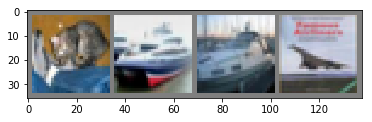

In [10]:
outputs = net(images)
_, predicted = torch.max(outputs.data, 1)


imshow(torchvision.utils.make_grid(images))
print('Predicted: ', ' '.join(['%5s' % classes[predicted[j]] for j in range(4)]))

### Test Accuracy 

In [11]:
########################################################################
# Let us look at how the network performs on the test dataset.

def test(testloader, model):
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for data in tqdm(testloader):
            # get the inputs
            inputs, labels = data
            if torch.cuda.is_available():
                inputs, labels = inputs.cuda(), labels.cuda()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)

            # addup loss
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 10000 test images: %d %%, loss = %f' % (
                                    100 * correct / total, running_loss / len(testloader)))
    return running_loss / len(testloader)


### Class-wise accuracy


In [12]:

def classwise_test(testloader, model):
########################################################################
# class-wise accuracy

    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    with torch.no_grad():
        for data in tqdm(testloader):
            images, labels = data
            if torch.cuda.is_available():
                images, labels = images.cuda(), labels.cuda()        
            outputs = net(images)
            _, predicted = torch.max(outputs, 1)
            c = (predicted == labels).squeeze()
            for i in range(4):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1

    for i in range(10):
        print('Accuracy of %5s : %2d %%' % (
            classes[i], 100 * class_correct[i] / class_total[i]))


In [13]:
import os
from tqdm import tqdm_notebook as tqdm
print('Start Training')
if not os.path.exists('./models'):
    os.mkdir('./models')

training_losses = []
testing_losses = []
num_epochs = 10

if torch.cuda.is_available():
    net = net.cuda()

for epoch in range(num_epochs):  # loop over the dataset multiple times
    print('epoch ', epoch + 1)
    train_loss = train(epoch, trainloader, optimizer, criterion)
    test_loss = test(testloader, net)
    classwise_test(testloader, net)
    torch.save(net.state_dict(), './models/model-'+str(epoch)+'.pth')
    
    training_losses.append(train_loss)
    testing_losses.append(test_loss)

print('Finished Training')



Start Training
epoch  1



epoch 1 training loss: 1.695



Accuracy of the network on the 10000 test images: 48 %, loss = 1.410905



Accuracy of plane : 45 %
Accuracy of   car : 71 %
Accuracy of  bird : 47 %
Accuracy of   cat : 35 %
Accuracy of  deer : 28 %
Accuracy of   dog : 30 %
Accuracy of  frog : 60 %
Accuracy of horse : 59 %
Accuracy of  ship : 71 %
Accuracy of truck : 38 %
epoch  2



epoch 2 training loss: 1.330



Accuracy of the network on the 10000 test images: 55 %, loss = 1.255348



Accuracy of plane : 66 %
Accuracy of   car : 65 %
Accuracy of  bird : 17 %
Accuracy of   cat : 36 %
Accuracy of  deer : 55 %
Accuracy of   dog : 55 %
Accuracy of  frog : 65 %
Accuracy of horse : 55 %
Accuracy of  ship : 72 %
Accuracy of truck : 64 %
epoch  3



epoch 3 training loss: 1.199



Accuracy of the network on the 10000 test images: 58 %, loss = 1.171690



Accuracy of plane : 68 %
Accuracy of   car : 70 %
Accuracy of  bird : 57 %
Accuracy of   cat : 41 %
Accuracy of  deer : 35 %
Accuracy of   dog : 50 %
Accuracy of  frog : 75 %
Accuracy of horse : 58 %
Accuracy of  ship : 64 %
Accuracy of truck : 66 %
epoch  4



epoch 4 training loss: 1.111



Accuracy of the network on the 10000 test images: 60 %, loss = 1.124986



Accuracy of plane : 73 %
Accuracy of   car : 75 %
Accuracy of  bird : 29 %
Accuracy of   cat : 35 %
Accuracy of  deer : 48 %
Accuracy of   dog : 56 %
Accuracy of  frog : 80 %
Accuracy of horse : 63 %
Accuracy of  ship : 69 %
Accuracy of truck : 67 %
epoch  5



epoch 5 training loss: 1.043



Accuracy of the network on the 10000 test images: 61 %, loss = 1.116149



Accuracy of plane : 47 %
Accuracy of   car : 72 %
Accuracy of  bird : 50 %
Accuracy of   cat : 50 %
Accuracy of  deer : 57 %
Accuracy of   dog : 45 %
Accuracy of  frog : 61 %
Accuracy of horse : 75 %
Accuracy of  ship : 78 %
Accuracy of truck : 74 %
epoch  6



epoch 6 training loss: 0.986



Accuracy of the network on the 10000 test images: 60 %, loss = 1.156445



Accuracy of plane : 72 %
Accuracy of   car : 71 %
Accuracy of  bird : 61 %
Accuracy of   cat : 28 %
Accuracy of  deer : 68 %
Accuracy of   dog : 43 %
Accuracy of  frog : 73 %
Accuracy of horse : 62 %
Accuracy of  ship : 68 %
Accuracy of truck : 54 %
epoch  7



epoch 7 training loss: 0.941



Accuracy of the network on the 10000 test images: 62 %, loss = 1.087578



Accuracy of plane : 62 %
Accuracy of   car : 87 %
Accuracy of  bird : 49 %
Accuracy of   cat : 36 %
Accuracy of  deer : 54 %
Accuracy of   dog : 50 %
Accuracy of  frog : 76 %
Accuracy of horse : 68 %
Accuracy of  ship : 82 %
Accuracy of truck : 62 %
epoch  8



epoch 8 training loss: 0.904



Accuracy of the network on the 10000 test images: 63 %, loss = 1.058562



Accuracy of plane : 76 %
Accuracy of   car : 81 %
Accuracy of  bird : 41 %
Accuracy of   cat : 55 %
Accuracy of  deer : 58 %
Accuracy of   dog : 50 %
Accuracy of  frog : 66 %
Accuracy of horse : 67 %
Accuracy of  ship : 78 %
Accuracy of truck : 63 %
epoch  9



epoch 9 training loss: 0.868



Accuracy of the network on the 10000 test images: 64 %, loss = 1.034586



Accuracy of plane : 67 %
Accuracy of   car : 72 %
Accuracy of  bird : 56 %
Accuracy of   cat : 53 %
Accuracy of  deer : 55 %
Accuracy of   dog : 48 %
Accuracy of  frog : 76 %
Accuracy of horse : 67 %
Accuracy of  ship : 79 %
Accuracy of truck : 73 %
epoch  10



epoch 10 training loss: 0.841



Accuracy of the network on the 10000 test images: 64 %, loss = 1.054989



Accuracy of plane : 68 %
Accuracy of   car : 80 %
Accuracy of  bird : 57 %
Accuracy of   cat : 40 %
Accuracy of  deer : 58 %
Accuracy of   dog : 48 %
Accuracy of  frog : 78 %
Accuracy of horse : 69 %
Accuracy of  ship : 77 %
Accuracy of truck : 66 %
Finished Training


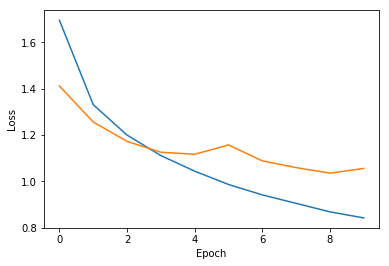

In [14]:
#Plotting the training graph
plt.plot(range(len(training_losses)), training_losses, label="train")
plt.plot(range(len(testing_losses)), testing_losses, label="test")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

## Loading saved model

In [15]:
new_net = Net()
new_net.load_state_dict(torch.load('./models/model-5.pth'))

## Miscellaneous APIs

### To numpy / From numpy

In [16]:
import torch
torch_tensor = torch.rand(3,3)
print(type(torch_tensor))
print(torch_tensor)

<class 'torch.Tensor'>
tensor([[0.0763, 0.7978, 0.0789],
        [0.6621, 0.2996, 0.4334],
        [0.8202, 0.8990, 0.4084]])


In [17]:
import numpy as np
np_array = torch_tensor.numpy()
print(type(np_array))
print(np_array)

<class 'numpy.ndarray'>
[[0.07625061 0.79781914 0.07890546]
 [0.6620777  0.29960775 0.43336773]
 [0.82024914 0.89902526 0.40844655]]


In [18]:
another_torch_tensor = torch.from_numpy(np_array)
print(type(another_torch_tensor))
print(another_torch_tensor)

<class 'torch.Tensor'>
tensor([[0.0763, 0.7978, 0.0789],
        [0.6621, 0.2996, 0.4334],
        [0.8202, 0.8990, 0.4084]])


## Transposing axis

In [25]:
from skimage import io
np_img = io.imread('../pics/ferrari.png')
print(np_img.shape)

(32, 32, 3)


In [26]:
np_img = np_img.transpose((2,0,1))
print(np_img.shape)

(3, 32, 32)


In [27]:
torch_img = torch.from_numpy(np_img)
print(torch_img.shape)

torch.Size([3, 32, 32])


## Squeeze/Unsqueeze

In [28]:
unsqueezed_img = torch_img.unsqueeze(0)
print(unsqueezed_img.shape)

torch.Size([1, 3, 32, 32])


In [29]:
squeezed_img = torch_img.squeeze(0)
print(squeezed_img.shape)

torch.Size([3, 32, 32])
